In [13]:
%reload_ext autoreload
%autoreload 2

In [14]:
import pandas as pd
import numpy as np
from numpy import load
import matplotlib.pyplot as plt
import tensorflow as tf

In [15]:
from projectwind.LSTM_data import WindowGenerator, get_LSTM_data, define_window
from projectwind.trainer import plot_loss

# Get Data

In [16]:
train_df, val_df, test_df = get_LSTM_data(25)

/home/jupyter/projectwind/raw_data
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


In [17]:
# Create window
n_steps_in =  48 * 6     # 48hrs x 6 periods of 10min
n_steps_out = 3 * 6    # 3hours x 6 periods of 10min
window = define_window(n_steps_in, n_steps_out, train_df, val_df, test_df)

In [18]:
# Load datasets
X_train = np.load("projectwind/data/LSTM_sequence_X_train_48-3.npy", allow_pickle=True).astype('float32')
y_train = np.load("./projectwind/data/LSTM_sequence_y_train_48-3.npy", allow_pickle=True).astype('float32')
X_val = np.load("./projectwind/data/LSTM_sequence_X_val_48-3.npy", allow_pickle=True).astype('float32')
y_val = np.load("./projectwind/data/LSTM_sequence_y_val_48-3.npy", allow_pickle=True).astype('float32')
X_test = np.load("./projectwind/data/LSTM_sequence_X_test_48-3.npy", allow_pickle=True).astype('float32')
y_test = np.load("./projectwind/data/LSTM_sequence_y_test_48-3.npy", allow_pickle=True).astype('float32')

In [19]:
# Load datasets
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)
X_val = tf.convert_to_tensor(X_val)
y_val = tf.convert_to_tensor(y_val)
X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)

# Build Model

In [20]:
val_performance = pd.DataFrame()
test_performance = pd.DataFrame()

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(n_steps_in, len(window.column_indices))),
    # Shape [batch, time, features] => [batch, lstm_units].
    tf.keras.layers.LSTM(500, return_sequences=True),
    tf.keras.layers.LSTM(500, return_sequences=True),
    tf.keras.layers.LSTM(500, return_sequences=True),
    tf.keras.layers.LSTM(500, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(n_steps_out),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([n_steps_out, 1])
])

In [22]:
model_name = '500N_4L_0do'

In [23]:
def compile_and_fit(model, window):
    
    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=50,
                                                      mode='min',
                                                      restore_best_weights=True)

    # Reduce learning rate by an order of magnitude if val_loss does not improve for 20 epoch
    rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.1, 
                                                 patience=10)
    
    model.compile(loss=tf.losses.Huber(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
    
    checkpoint=tf.keras.callbacks.ModelCheckpoint(f"./checkpoint/checkpoint_{model_name}.h5", save_best_only=True, save_weights_only=True)
    
    history = model.fit(X_train, y_train, 
                        epochs=500,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, checkpoint, rlrop])
    model.save(f'./checkpoint/LSTM_basic_{model_name}.h5')
    return history

# Run Model

In [24]:
history = compile_and_fit(model, window)

2022-02-14 13:23:18.790288: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500


2022-02-14 13:23:23.147002: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


226/226 [==============================] - 49s 196ms/step - loss: 669.6295 - mean_absolute_error: 670.1294 - val_loss: 854.0321 - val_mean_absolute_error: 854.5318
Epoch 2/500
226/226 [==============================] - 44s 196ms/step - loss: 607.1833 - mean_absolute_error: 607.6832 - val_loss: 790.2622 - val_mean_absolute_error: 790.7620
Epoch 3/500
226/226 [==============================] - 45s 201ms/step - loss: 567.7401 - mean_absolute_error: 568.2402 - val_loss: 743.8683 - val_mean_absolute_error: 744.3682
Epoch 4/500
226/226 [==============================] - 46s 204ms/step - loss: 543.2081 - mean_absolute_error: 543.7077 - val_loss: 710.7827 - val_mean_absolute_error: 711.2825
Epoch 5/500
226/226 [==============================] - 47s 208ms/step - loss: 529.0269 - mean_absolute_error: 529.5266 - val_loss: 688.0137 - val_mean_absolute_error: 688.5134
Epoch 6/500
226/226 [==============================] - 47s 210ms/step - loss: 521.3909 - mean_absolute_error: 521.8907 - val_loss: 6

In [25]:
val_performance[model_name] = model.evaluate(X_val, y_val)
test_performance[model_name] = model.evaluate(X_test, y_test)

33/33 [==============================] - 2s 71ms/step - loss: 617.4744 - mean_absolute_error: 617.9744


2022-02-14 14:23:33.161681: W tensorflow/core/common_runtime/bfc_allocator.cc:457] Allocator (GPU_0_bfc) ran out of memory trying to allocate 19.38GiB (rounded to 20808000000)requested by op CudnnRNN
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-02-14 14:23:33.161737: I tensorflow/core/common_runtime/bfc_allocator.cc:1004] BFCAllocator dump for GPU_0_bfc
2022-02-14 14:23:33.161755: I tensorflow/core/common_runtime/bfc_allocator.cc:1011] Bin (256): 	Total Chunks: 57, Chunks in use: 57. 14.2KiB allocated for chunks. 14.2KiB in use in bin. 769B client-requested in use in bin.
2022-02-14 14:23:33.161783: I tensorflow/core/common_runtime/bfc_allocator.cc:1011] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2022-02-14 14:23:33.161794: I tensorflow/core/

InternalError: Failed to call ThenRnnForward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 2, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 10, 500, 1, 288, 7225, 500]  [Op:CudnnRNN]

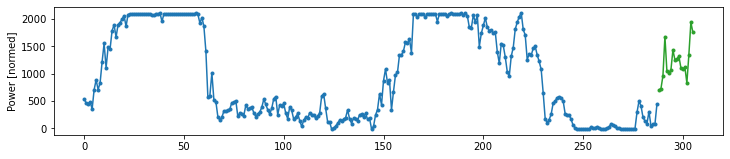

In [26]:
window.plot(model)

In [ ]:
plot_loss(history)

# Load Latest Model